In [1]:
import os
import numpy as np
import pandas as pd

from gurobipy import *

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
m = Model('system')

arcs = [
    ("GRID", "ELEC"),
    ("GRID", "HP"),
    ("HP", "HEAT"),
    ("GAS", "CHP"),
    ("CHP", "ELEC"),
    ("CHP", "HEAT")
]

Academic license - for non-commercial use only


In [4]:
load_elec = pd.read_csv("load_elec.csv", index_col=0, squeeze=True)
load_heat = pd.read_csv("load_heat.csv", index_col=0, squeeze=True)

In [5]:
nb_of_periods = len(load_elec)

flows = m.addVars(arcs, nb_of_periods, name="flows")

In [6]:
cop = 3.0

cstr_hp = m.addConstrs(
    (cop * flows["GRID", "HP", i] - flows["HP", "HEAT", i] == 0 
     for i in range(nb_of_periods)))

In [7]:
eff_heat = 0.4
eff_elec = 0.3

cstr_chp_heat = m.addConstrs(
    (eff_heat * flows["GAS", "CHP", i] - flows["CHP", "HEAT", i] == 0 
     for i in range(nb_of_periods)))

cstr_chp_elec = m.addConstrs(
    (eff_elec * flows["GAS", "CHP", i] - flows["CHP", "ELEC", i] == 0 
     for i in range(nb_of_periods)))

In [8]:
cstr_load_elec = m.addConstrs(
    (flows.sum('*', "ELEC", i) == load_elec.iloc[i]
     for i in range(nb_of_periods)))

cstr_load_heat = m.addConstrs(
    (flows.sum('*', "HEAT", i) == load_heat.iloc[i]
     for i in range(nb_of_periods)))

In [9]:
cstr_max_hp = m.addConstrs(
    (flows["GAS", "CHP", i] <= 100
     for i in range(nb_of_periods)))

In [10]:
m.setObjective(flows.sum("GRID", '*', '*'), GRB.MINIMIZE)
m.optimize()

Optimize a model with 144 rows, 144 columns and 264 nonzeros
Coefficient statistics:
  Matrix range     [3e-01, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 2e+02]
Presolve removed 144 rows and 144 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1334096e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.133409603e+03


In [11]:
index = pd.date_range(start="2019/03/11", freq="1H", periods=nb_of_periods)
results = pd.DataFrame(index=index)
for a in arcs:
    results["{}_{}".format(a[0], a[1])] = [round(flows[a[0], a[1], i].x, 2) for i in range(nb_of_periods)]

In [12]:
results.head()

,GRID_ELEC,GRID_HP,HP_HEAT,GAS_CHP,CHP_ELEC,CHP_HEAT
2019-03-11 00:00:00,25.23,27.57,82.70,100.0,30.0,40.0
2019-03-11 01:00:00,25.21,29.50,88.51,100.0,30.0,40.0
2019-03-11 02:00:00,25.52,28.14,84.41,100.0,30.0,40.0
2019-03-11 03:00:00,25.02,34.48,103.44,100.0,30.0,40.0
2019-03-11 04:00:00,28.02,34.31,102.93,100.0,30.0,40.0


<IPython.core.display.Javascript object>


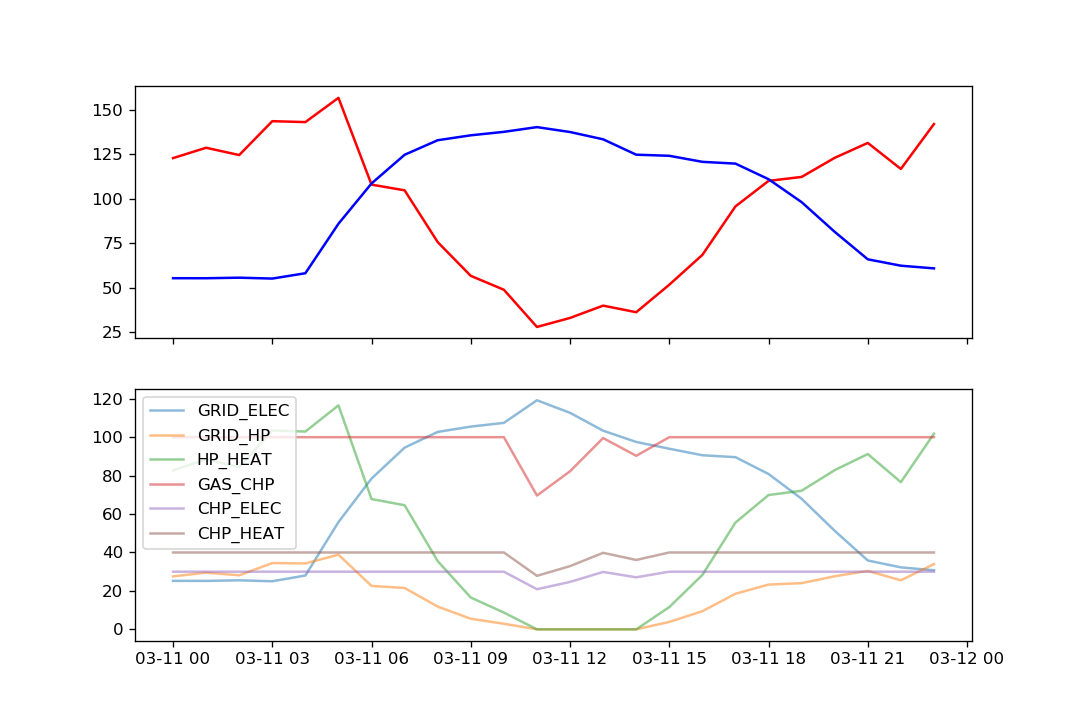

In [13]:
fig, ax = plt.subplots(2, figsize=(9, 6), sharex=True)

ax[0].plot(index, load_heat, "r-")
ax[0].plot(index, load_elec, "b-")

for c in results.columns:
    ax[1].plot(results[c], alpha=0.5, label=c)

ax[1].legend()

<IPython.core.display.Javascript object>


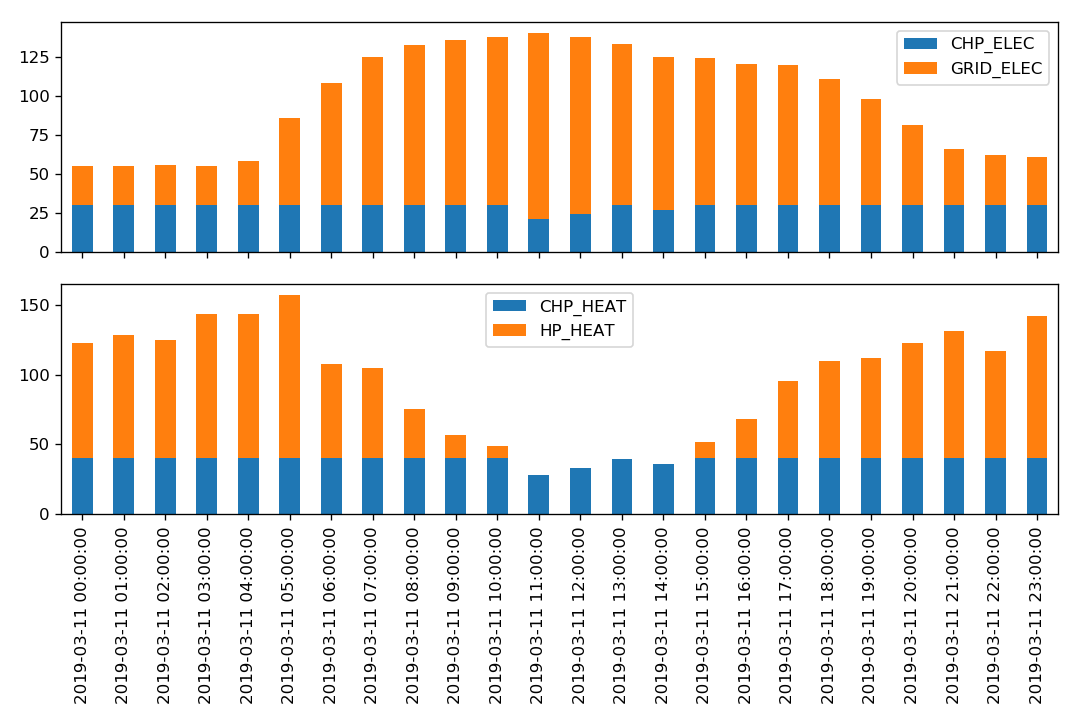

In [14]:
fig, ax = plt.subplots(2, figsize=(9, 6), sharex=True)

results.loc[:, ["CHP_ELEC", "GRID_ELEC"]].plot(kind='bar', stacked=True, ax=ax[0])
results.loc[:, ["CHP_HEAT", "HP_HEAT"]].plot(kind='bar', stacked=True, ax=ax[1])

plt.tight_layout()